- This note referenced codes below:
    -  https://www.kaggle.com/code/ambrosm/ecg-original-explained-baseline#Solution-2:-A-neural-network-for-digitizing-grayscale-images
    - https://github.com/felixkrones/ECG-Digitiser/tree/main

## 0. Import Libraries + Utils

In [ ]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [ ]:
from typing import Tuple

import numpy as np
import pandas as pd

import scipy.optimize
import scipy.signal


LEADS = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
MAX_TIME_SHIFT = 0.2
PERFECT_SCORE = 384


class ParticipantVisibleError(Exception):
    pass


def compute_power(label: np.ndarray, prediction: np.ndarray) -> Tuple[float, float]:
    if label.ndim != 1 or prediction.ndim != 1:
        raise ParticipantVisibleError('Inputs must be 1-dimensional arrays.')
    finite_mask = np.isfinite(prediction)
    if not np.any(finite_mask):
        raise ParticipantVisibleError("The 'prediction' array contains no finite values (all NaN or inf).")

    prediction[~np.isfinite(prediction)] = 0
    noise = label - prediction
    p_signal = np.sum(label**2)
    p_noise = np.sum(noise**2)
    return p_signal, p_noise


def compute_snr(signal: float, noise: float) -> float:
    if noise == 0:
        # Perfect reconstruction
        snr = PERFECT_SCORE
    elif signal == 0:
        snr = 0
    else:
        snr = min((signal / noise), PERFECT_SCORE)
    return snr


def align_signals(label: np.ndarray, pred: np.ndarray, max_shift: float = float('inf')) -> np.ndarray:
    if np.any(~np.isfinite(label)):
        raise ParticipantVisibleError('values in label should all be finite')
    if np.sum(np.isfinite(pred)) == 0:
        raise ParticipantVisibleError('prediction can not all be infinite')

    # Initialize the reference and digitized signals.
    label_arr = np.asarray(label, dtype=np.float64)
    pred_arr = np.asarray(pred, dtype=np.float64)

    label_mean = np.mean(label_arr)
    pred_mean = np.mean(pred_arr)

    label_arr_centered = label_arr - label_mean
    pred_arr_centered = pred_arr - pred_mean

    # Compute the correlation between the reference and digitized signals and locate the maximum correlation.
    correlation = scipy.signal.correlate(label_arr_centered, pred_arr_centered, mode='full')

    n_label = np.size(label_arr)
    n_pred = np.size(pred_arr)

    lags = scipy.signal.correlation_lags(n_label, n_pred, mode='full')
    valid_lags_mask = (lags >= -max_shift) & (lags <= max_shift)

    max_correlation = np.nanmax(correlation[valid_lags_mask])
    all_max_indices = np.flatnonzero(correlation == max_correlation)
    best_idx = min(all_max_indices, key=lambda i: abs(lags[i]))
    time_shift = lags[best_idx]
    start_padding_len = max(time_shift, 0)
    pred_slice_start = max(-time_shift, 0)
    pred_slice_end = min(n_label - time_shift, n_pred)
    end_padding_len = max(n_label - n_pred - time_shift, 0)
    aligned_pred = np.concatenate((np.full(start_padding_len, np.nan), pred_arr[pred_slice_start:pred_slice_end], np.full(end_padding_len, np.nan)))

    def objective_func(v_shift):
        return np.nansum((label_arr - (aligned_pred - v_shift)) ** 2)

    if np.any(np.isfinite(label_arr) & np.isfinite(aligned_pred)):
        results = scipy.optimize.minimize_scalar(objective_func, method='Brent')
        vertical_shift = results.x
        aligned_pred -= vertical_shift
    return aligned_pred


def _calculate_image_score(group: pd.DataFrame) -> float:
    """Helper function to calculate the total SNR score for a single image group."""

    unique_fs_values = group['fs'].unique()
    if len(unique_fs_values) != 1:
        raise ParticipantVisibleError('Sampling frequency should be consistent across each ecg')
    sampling_frequency = unique_fs_values[0]
    if sampling_frequency != int(len(group[group['lead'] == 'II']) / 10):
        raise ParticipantVisibleError('The sequence_length should be sampling frequency * 10s')
    sum_signal = 0
    sum_noise = 0
    for lead in LEADS:
        sub = group[group['lead'] == lead]
        label = sub['value_true'].values
        pred = sub['value_pred'].values

        aligned_pred = align_signals(label, pred, int(sampling_frequency * MAX_TIME_SHIFT))
        p_signal, p_noise = compute_power(label, aligned_pred)
        sum_signal += p_signal
        sum_noise += p_noise
    return compute_snr(sum_signal, sum_noise)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Compute the mean Signal-to-Noise Ratio (SNR) across multiple ECG leads and images for the PhysioNet 2025 competition.
    The final score is the average of the sum of SNRs over different lines, averaged over all unique images.
    Args:
        solution: DataFrame with ground truth values. Expected columns: 'id' and one for each lead.
        submission: DataFrame with predicted values. Expected columns: 'id' and one for each lead.
        row_id_column_name: The name of the unique identifier column, typically 'id'.
    Returns:
        The final competition score.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> row_id_column_name = "id"
    >>> solution = pd.DataFrame({'id': ['343_0_I', '343_1_I', '343_2_I', '343_0_III', '343_1_III','343_2_III','343_0_aVR', '343_1_aVR','343_2_aVR',\
    '343_0_aVL', '343_1_aVL', '343_2_aVL', '343_0_aVF', '343_1_aVF','343_2_aVF','343_0_V1', '343_1_V1', '343_2_V1','343_0_V2', '343_1_V2','343_2_V2',\
    '343_0_V3', '343_1_V3', '343_2_V3','343_0_V4', '343_1_V4', '343_2_V4', '343_0_V5', '343_1_V5','343_2_V5','343_0_V6', '343_1_V6','343_2_V6',\
    '343_0_II', '343_1_II','343_2_II', '343_3_II', '343_4_II', '343_5_II','343_6_II', '343_7_II','343_8_II','343_9_II','343_10_II','343_11_II'],\
    'fs': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],\
    'value':[0.1,0.3,0.4,0.6,0.6,0.4,0.2,0.3,0.4,0.5,0.2,0.7,0.2,0.3,0.4,0.8,0.6,0.7, 0.2,0.3,-0.1,0.5,0.6,0.7,0.2,0.9,0.4,0.5,0.6,0.7,0.1,0.3,0.4,\
    0.6,0.6,0.4,0.2,0.3,0.4,0.5,0.2,0.7,0.2,0.3,0.4]})
    >>> submission = solution.copy()
    >>> round(score(solution, submission, row_id_column_name), 4)
    25.8433
    >>> submission.loc[0, 'value'] = 0.9 # Introduce some noise
    >>> round(score(solution, submission, row_id_column_name), 4)
    13.6291
    >>> submission.loc[4, 'value'] = 0.3 # Introduce some noise
    >>> round(score(solution, submission, row_id_column_name), 4)
    13.0576

    >>> solution = pd.DataFrame({'id': ['343_0_I', '343_1_I', '343_2_I', '343_0_III', '343_1_III','343_2_III','343_0_aVR', '343_1_aVR','343_2_aVR',\
    '343_0_aVL', '343_1_aVL', '343_2_aVL', '343_0_aVF', '343_1_aVF','343_2_aVF','343_0_V1', '343_1_V1', '343_2_V1','343_0_V2', '343_1_V2','343_2_V2',\
    '343_0_V3', '343_1_V3', '343_2_V3','343_0_V4', '343_1_V4', '343_2_V4', '343_0_V5', '343_1_V5','343_2_V5','343_0_V6', '343_1_V6','343_2_V6',\
    '343_0_II', '343_1_II','343_2_II', '343_3_II', '343_4_II', '343_5_II','343_6_II', '343_7_II','343_8_II','343_9_II','343_10_II','343_11_II'],\
    'fs': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],\
    'value':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]})
    >>> round(score(solution, submission, row_id_column_name), 4)
    -384
    >>> submission = solution.copy()
    >>> round(score(solution, submission, row_id_column_name), 4)
    25.8433

    >>> # test alignment
    >>> label = np.array([0, 1, 2, 1, 0])
    >>> pred = np.array([0, 1, 2, 1, 0])
    >>> aligned = align_signals(label, pred)
    >>> expected_array = np.array([0, 1, 2, 1, 0])
    >>> np.allclose(aligned, expected_array, equal_nan=True)
    True

    >>> # Test 2: Vertical shift (DC offset) should be removed
    >>> label = np.array([0, 1, 2, 1, 0])
    >>> pred = np.array([10, 11, 12, 11, 10])
    >>> aligned = align_signals(label, pred)
    >>> expected_array = np.array([0, 1, 2, 1, 0])
    >>> np.allclose(aligned, expected_array, equal_nan=True)
    True

    >>> # Test 3: Time shift should be corrected
    >>> label = np.array([0, 0, 1, 2, 1, 0., 0.])
    >>> pred = np.array([1, 2, 1, 0, 0, 0, 0])
    >>> aligned = align_signals(label, pred)
    >>> expected_array = np.array([np.nan, np.nan, 1, 2, 1, 0, 0])
    >>> np.allclose(aligned, expected_array, equal_nan=True)
    True

    >>> # Test 4: max_shift constraint prevents optimal alignment
    >>> label = np.array([0, 0, 0, 0, 1, 2, 1]) # Peak is far
    >>> pred = np.array([1, 2, 1, 0, 0, 0, 0])
    >>> aligned = align_signals(label, pred, max_shift=10)
    >>> expected_array = np.array([ np.nan, np.nan, np.nan, np.nan, 1, 2, 1])
    >>> np.allclose(aligned, expected_array, equal_nan=True)
    True

    """
    for df in [solution, submission]:
        if row_id_column_name not in df.columns:
            raise ParticipantVisibleError(f"'{row_id_column_name}' column not found in DataFrame.")
        if df['value'].isna().any():
            raise ParticipantVisibleError('NaN exists in solution/submission')
        if not np.isfinite(df['value']).all():
            raise ParticipantVisibleError('Infinity exists in solution/submission')

    submission = submission[['id', 'value']]
    merged_df = pd.merge(solution, submission, on=row_id_column_name, suffixes=('_true', '_pred'))
    merged_df['image_id'] = merged_df[row_id_column_name].str.split('_').str[0]
    merged_df['row_id'] = merged_df[row_id_column_name].str.split('_').str[1].astype('int64')
    merged_df['lead'] = merged_df[row_id_column_name].str.split('_').str[2]
    merged_df.sort_values(by=['image_id', 'row_id', 'lead'], inplace=True)
    image_scores = merged_df.groupby('image_id').apply(_calculate_image_score, include_groups=False)
    return max(float(10 * np.log10(image_scores.mean())), -PERFECT_SCORE)

In [ ]:
def apply_einthoven(preds):
    """Apply Einthoven's law to improve the predictions.

    The three equalities are
    I + III - II = 0
    aVR + avL + aVF = 0
    2 * aVR - 2 * aVF + 3 * II = 0

    Parameters:
    pred: dict of time series, will be updated
    """
    residual = preds['I'] + preds['III'] - preds['II'][:len(preds['III'])]
    correction = residual / 3
    preds['I'] -= correction
    preds['III'] -= correction
    preds['II'][:len(preds['III'])] += correction

    residual = preds['aVR'] + preds['aVL'] + preds['aVF']
    correction = residual / 3
    preds['aVR'] -= correction
    preds['aVL'] -= correction
    preds['aVF'] -= correction

    residual = 2 * preds['aVR'] - 2 * preds['aVF'] + 3 * preds['II'][len(preds['I']):len(preds['I'])+len(preds['aVR'])]
    correction = residual / 17
    preds['aVR'] -= 2 * correction
    preds['aVF'] += 2 * correction
    preds['II'][len(preds['I']):len(preds['I'])+len(preds['aVR'])] -= 3 * correction

## 1. Load Files

In [ ]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = 'drive/MyDrive/ml_project'

In [ ]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/test.csv')

In [ ]:
# Retrieving every csv
label_dict = {}
for idx, row in tqdm(train.iterrows(), total=len(train)):
  label_dict[idx] = pd.read_csv(f'{DATA_PATH}/train/{row.id}/{row.id}.csv')

100%|██████████| 977/977 [18:51<00:00,  1.16s/it]


## 3. Detect Markers

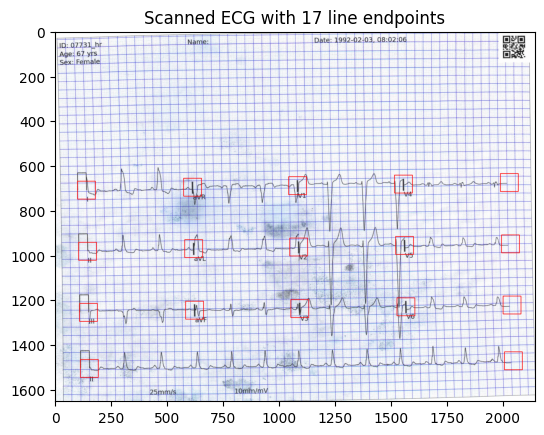

In [ ]:
class MarkerFinder:
    """This class finds the 13 markers in scanned ecg images and guesses the 4 line ends."""
    # From https://www.kaggle.com/code/ambrosm/ecg-original-explained-baseline

    def __init__(self, show_templates=False):
        # Derive the templates from type 1 images
        # np.max keeps the gridlines and markers and removes the ecg lines
        ima = np.max([
            cv2.imread(f'{DATA_PATH}/train/4292118763/4292118763-0001.png'),
            cv2.imread(f'{DATA_PATH}/train/4289880010/4289880010-0001.png'),
            cv2.imread(f'{DATA_PATH}/train/4284351157/4284351157-0001.png'),
        ], axis=0)

        # Template points in global coordinates of type 1 images
        absolute_points = np.zeros((17, 2), dtype=int)
        for i in range(3):
            absolute_points[5 * i] = np.array([707 + 284 * i, 118]) # y, x
            for j in range(1, 5):
                absolute_points[5 * i + j] = np.array([707 + 284 * i, 118 + 492 * j])
        absolute_points[5 * 3] = np.array([1535, 118])
        absolute_points[5 * 3 + 1] = np.array([1535, 118 + 492 * 4])

        # Top left corner of template rectangle
        template_positions = [None] * 17
        for i in range(len(absolute_points)):
            if absolute_points[i][1] < 118 + 492 * 4:
                if i % 5 == 0:
                    template_positions[i] = (absolute_points[i][0] - 87, absolute_points[i][1] - 50) # y, x
                else:
                    template_positions[i] = (absolute_points[i][0] - 37, absolute_points[i][1] - 13)

        # Height and width of the templates
        template_sizes = np.array([(105, 60)] * 17) # height, width

        # Transform the points to relative coordinates (inside the template)
        template_points = [np.array([absolute_points[i][0] - template_positions[i][0],
                                     absolute_points[i][1] - template_positions[i][1]])
                           if template_positions[i] is not None
                           else None
                           for i in range(len(absolute_points))]

        # Save the template matrices
        templates = [None] * 17
        for i in range(len(template_positions)):
            if template_points[i] is not None:
                template = (ima[template_positions[i][0]:template_positions[i][0]+template_sizes[i][0],
                            template_positions[i][1]:template_positions[i][1]+template_sizes[i][1]])
                templates[i] = template

        # Plot the template matrices
        if show_templates:
            _, axs = plt.subplots(4, 4, figsize=(5, 7))
            for i in range(len(template_positions)):
                if template_points[i] is not None:
                    template = templates[i].copy()
                    cv2.rectangle(template,
                                  (template_points[i][1]-1, template_points[i][0]-1),
                                  (template_points[i][1]+1, template_points[i][0]+1),
                                  [255, 0, 0], 2)
                    axs[i // 5, i % 5].imshow(template)
            for i in range(13, len(axs.ravel())):
                axs.ravel()[i].axis('off')
            plt.tight_layout()
            plt.suptitle('The templates for the 13 markers', y=1.01)
            plt.show()

        self._absolute_points = absolute_points
        self._template_positions = template_positions
        self._template_sizes = template_sizes
        self._template_points = template_points
        self._templates = templates

    def find_markers(self, ima, warn=False, plot=False, title=''):
        """Return 17 markers as list of size-2 integer arrays (row, column)

        Parameters:
        ima: array of shape (1652, height, 3)
        """

        if ima.shape[0] != 1652:
            raise ValueError("Implemented only for scanned images (image types 3, 4, 11, 12)")

        markers = np.full((17, 2), -1)

        # Find 13 template-based markers
        for j in range(len(self._templates)):
            if self._template_points[j] is not None:
                t = self._template_positions[j][0]-100
                l = max(self._template_positions[j][1]-100, 0)
                search_range = (ima[t:self._template_positions[j][0]+100+self._template_sizes[j][0],
                                l:self._template_positions[j][1]+250+self._template_sizes[j][0]])
                res = cv2.matchTemplate(search_range, self._templates[j], cv2.TM_CCOEFF)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                top_left = max_loc
                if warn and max_val < 3e7:
                    bottom_right = (top_left[0] + self._templates[j].shape[1],
                                    top_left[1] + self._templates[j].shape[0])
                    print(j, top_left, max_val)
                    search_range = search_range.copy()
                    cv2.rectangle(search_range, top_left, bottom_right, 0, 2)
                    plt.imshow(search_range)
                    plt.show()
                markers[j] = np.array((t + top_left[1] + self._template_points[j][0],
                                       l + top_left[0] + self._template_points[j][1]))

        # Guess the ends of the first three lines (can be outside the bounding box of the image)
        for i in range(3):
            m = markers[5 * i + 3] * 2 - markers[5 * i + 2]
            markers[5 * i + 4] = m

        # Guess the end of the fourth line (can be outside the bounding box of the image)
        markers[16] = ((markers[14] * (284 + 260) - markers[9] * 260) / 284).astype(int)

        if plot:
            ima = ima.copy()
            for m in markers:
                if m is not None:
                    cv2.rectangle(ima, (m[1]-40, m[0]-40), (m[1]+40, m[0]+40), (255, 0, 0), 2)
            # plt.figure(figsize=(12, 8))
            plt.imshow(ima)
            plt.title(title)
            plt.show()

        return markers

    # def baseline(self, i):
    #     """y coordinate of ith baseline in type 1 images"""
    #     if i not in [0, 1, 2, 3]:
    #         raise ValueError("i must be in [0, 1, 2, 3]")
    #     return self._absolute_points[5 * i][0]

    @staticmethod
    def lead_info(lead):
        """Specify which markers mark the begin and the end of a lead."""
        begin, end = {
            'I': (0, 1),
            'II-subset': (5, 6),
            'III': (10, 11),
            'aVR': (1, 2),
            'aVL': (6, 7),
            'aVF': (11, 12),
            'V1': (2, 3),
            'V2': (7, 8),
            'V3': (12, 13),
            'V4': (3, 4),
            'V5': (8, 9),
            'V6': (13, 14),
            'II': (15, 16),
        }[lead]
        return begin // 5, begin, end

    def demo(self, ima, warn=False, title=''):
        """Plot the image with red markers"""
        markers = self.find_markers(ima, warn, plot=True, title=title)

mf = MarkerFinder(show_templates=False)

ima = cv2.imread(f'{DATA_PATH}/train/1026034238/1026034238-0011.png') # correct
mf.demo(ima, warn=False, title='Scanned ECG with 17 line endpoints')

In [ ]:
# Optional: load the stored train set

import numpy as np

# Load file
data = np.load(f'{DATA_PATH}/dataset_full_1m.npz')

X = data['X']
y = data['y']

print(f"Load complete! X size: {X.shape}, Y size: {y.shape}")

In [ ]:
# Preparing the training data
n_train_nn, n_training_samples_per_line = 1000000, 30
h0, w0 = 600, 11

X = np.zeros((n_train_nn, h0 * w0), dtype=np.float32)
y = np.zeros((n_train_nn, ), dtype=np.float32)

def prepare_dataset(train):
    i_train_nn = 0
    rng = np.random.default_rng(1)
    t = tqdm(total=n_train_nn, position=0)
    for idx, row in train.iterrows():
        labels = pd.read_csv(f'{DATA_PATH}/train/{row.id}/{row.id}.csv')
        png_paths = sorted(glob(f'{DATA_PATH}/train/{row.id}/{row.id}-*.png'))
        for path in png_paths:
            img_type = int(path[-8:-4])
            if img_type in [4, 12]:
                ima = cv2.imread(path)
                markers = mf.find_markers(ima)
                ima = ima.mean(axis=2)
                ll = np.array([labels['aVR'].fillna(0) + labels['V1'].fillna(0),
                               labels['aVL'].fillna(0) + labels['V2'].fillna(0),
                               labels['aVF'].fillna(0) + labels['V3'].fillna(0),])
                for i in range(3):
                    for j in range(1, 3):
                        yl, xl = markers[5*i+j]
                        yp, xp = markers[5*i+j+1] - markers[5*i+j]
                        lead = ['', 'aVR', 'V1', '', '', '', 'aVL', 'V2', '', '', '' ,'aVF', 'V3'][5*i+j]
                        l = labels[lead]
                        l = l[~l.isna()]
                        l = np.interp(np.linspace(0, 1, xp),
                                      np.linspace(0, 1, len(l)),
                                      l) * 80 # true labels in pixel coordinates
                        assert xp > 0 # yp may be negative
                        for k in range(n_training_samples_per_line):
                            alpha = rng.uniform()
                            x0, y0 = int(xl + alpha * xp), int(yl + alpha * yp)
                            X[i_train_nn] = ima[y0-h0//2:y0+h0//2, x0-w0//2:x0+w0//2+1].ravel()
                            y[i_train_nn] = h0 / 2 - l[x0-xl]
                            i_train_nn += 1
                            t.update(1)
                            if i_train_nn == n_train_nn:
                                t.close()
                                print(f"last idx used: {idx}")
                                return

prepare_dataset(train.iloc)
print(X.shape, y.shape, X.size*4)
X_orig = X.copy()
X = X / 255.0 - 1 # offset so that X.max() = 0
assert np.isfinite(X).all()
assert np.isfinite(y).all()

# X is a scaled pixel intensity, 0 = white, -1 = black
# y is amplitude in pixels, usually between 0 and h0-1, h0//2 is baseline. In rare cases it is below 0 or above h0

(120000, 6600) (120000,) 3168000000


In [ ]:
# Optional: save train set as a numpy array

import numpy as np

save_path = f'{DATA_PATH}/dataset_full_1m.npz'

print("Start saving dataset...")

np.savez_compressed(save_path, X=X, y=y)

print(f"Save complete! File name : {save_path}")

## 4. Train

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Input, Dense, Activation, Reshape, GaussianNoise
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [ ]:
def plot_training_history(history):
    """Plot a Keras training history."""
    if len(history['loss']) >= 2:
        _, axs = plt.subplots(1, 1, figsize=(6, 3), squeeze=False)
        axs = axs.ravel()
        axs[0].plot(np.arange(len(history['loss'])) + 1, history['loss'], ':', label='train_loss')
        axs[0].plot(np.arange(len(history['val_loss'])) + 1, history['val_loss'], label='val_loss')
        axs[0].legend()
        axs[0].set_title('Training history')
        plt.show()

In [ ]:
def fit_model(model, initial_lr, batch_size=2048, epochs=70, verbose=2):
    grayscale_model_list = []
    oof = np.zeros_like(y)
    kf = KFold(shuffle=True, random_state=1)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X)):
        X_tr = X[idx_tr]
        X_va = X[idx_va]
        y_tr = y[idx_tr]
        y_va = y[idx_va]

        # Train the complete model
        model.compile(
            optimizer=Adam(learning_rate=initial_lr),
            loss=MeanSquaredError(),
        )
        print(y_va.var())
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[EarlyStopping(patience=6, min_delta=0.1),
                    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, min_delta=0.1, min_lr=initial_lr/63),
                    TerminateOnNaN()],
            verbose=verbose
        )
        history = history.history
        plot_training_history(history)

        y_pred = model.predict(X_va, batch_size=1024, verbose=0).ravel()
        oof[idx_va] = y_pred
        mse = np.square(y_va - y_pred).mean()
        r2 = r2_score(y_va, y_pred)
        print(f'# Fold {fold} {mse:6.2f} {r2:4.2f} {np.var(y_va):6.2f} {len(X)}*{h0}*{w0} {batch_size}\n')
        grayscale_model_list.append(model)

        # Regression
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.hist(y, bins=50, density=True, label='y_true')
        plt.hist(y_pred, bins=50, density=True, alpha=0.6, label='y_pred')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.scatter(y_pred, y_va, s=1)
        plt.xlabel('y_pred')
        plt.ylabel('y_true')
        plt.gca().set_aspect('equal')
        plt.show()
    return grayscale_model_list

In [ ]:
def train_images_and_labels(start=None, end=None, image_types=None, use_tqdm=True):
    """Generator function which yields a subset of the training images.

    Parameters
    start: start index of slice
    end: end index of slice
    image_types: list of image types to select
    """
    t = train.iloc[start:end]
    iterable = t.iterrows()
    if use_tqdm:
        iterable = tqdm(iterable, total=len(t))
    for idx, row in iterable:
        png_paths = sorted(glob(f'{DATA_PATH}/train/{row.id}/{row.id}-*.png'))
        labels = label_dict[idx]
        for path in png_paths:
            img_type = int(path[-8:-4])
            if image_types is None or img_type in image_types:
                ima = cv2.imread(path)

                # The following lines document the possible shapes for every image type in train
                # Test files may be different
                shape = ima.shape
                assert len(shape) == 3
                assert (img_type == 1) <= (shape == (1700, 2200, 3)) # 200 pixels per inch on Letter paper
                assert (img_type == 3) <= (shape[0] == 1652)
                assert (img_type == 4) <= (shape[0] == 1652)
                assert (img_type == 5) <= (shape in {(3024, 4032, 3), (1344, 1008, 3), (4032, 3024, 3)})
                assert (img_type == 6) <= ((shape == (4000, 3000, 3) or (shape == (3000, 4000, 3))))
                assert (img_type == 9) <= ((shape == (3024, 4032, 3) or (shape == (4032, 3024, 3))))
                assert (img_type == 10) <= ((shape == (3024, 4032, 3) or (shape == (4032, 3024, 3))))
                assert (img_type == 11) <= (shape[0] == 1652)
                assert (img_type == 12) <= (shape[0] == 1652)

                yield idx, ima, img_type, labels

In [ ]:
def validate_algorithm(convert, start=None, end=None, image_types=None):
    """Convert a few training images, plot the output and compute the signal-to-noise ratio"""
    if len(test) != 24:
        # test file when saving has 2*12=24 rows
        return # when submitting, nobody will see the validation output
    snr_list = []
    index_list = []
    is_first_ecg = True # we plot only the images of the first ECG
    for idx, ima, img_type, labels in train_images_and_labels(start=start,
                                                              end=end,
                                                              image_types=image_types,
                                                              use_tqdm=False):

        # Find the 17 line endpoints
        markers = mf.find_markers(ima, plot=is_first_ecg, title='Image with 17 markers')

        # Convert the image to 12 leads
        n_timesteps = {lead: (~ labels[lead].isna()).sum() for lead in LEADS}
        preds = convert(ima, markers, n_timesteps, verbose=is_first_ecg)

        # Evaluate the signal-to-noise ratio, plot y_true vs. y_pred
        if is_first_ecg:
            _, axs = plt.subplots(6, 2, figsize=(12, 14))
        sum_signal = 0
        sum_noise = 0
        for i, lead in enumerate(LEADS):
            label = labels[lead]
            label = label[~ label.isna()]
            pred = preds[lead]

            aligned_pred = align_signals(label, pred, int(row.fs * MAX_TIME_SHIFT))
            p_signal, p_noise = compute_power(label, aligned_pred)
            sum_signal += p_signal
            sum_noise += p_noise

            if is_first_ecg:
                ax = axs.T.ravel()[i]
                ax.set_title(lead)
                ax.plot(label.values, label='y_true')
                ax.plot(pred, label='y_pred')
                ax.set_xlabel('timestep')
                ax.set_ylabel('mV')
                ax.legend()
        if is_first_ecg:
            plt.tight_layout()
            plt.suptitle('y_true vs. y_pred', y=1.01)
            plt.show()
        snr = compute_snr(sum_signal, sum_noise)
        print(f"{idx=:4d} {img_type=:2d} SNR: {snr:5.2f}")
        snr_list.append(snr)
        index_list.append([idx, img_type])

        if is_first_ecg:
            print('\n')
            is_first_ecg = False

    print(np.array(snr_list).mean(), len(snr_list))
    snr = (np.array(snr_list).mean() - 1) / 9 * len(image_types) + 1
    val_score = max(float(10 * np.log10(snr)), -PERFECT_SCORE)
    print(f"# Average SNR: {snr:.2f} {val_score=:.2f} {image_types}")
    snr_df = pd.DataFrame(index_list, columns=['idx', 'type'])
    snr_df['snr'] = snr_list
    snr_df.to_csv('~snr.csv', index=False)

In [ ]:
def get_grayscale_lead(ima, lead, n_timesteps, markers):
    """Extract and resample one lead from an ECG image.

    The function returns the time series if possible, or it gives up and returns None.

    Parameters:
    ima: single-channel (grayscale image)
    lead: one of the 12 lead labels (string)
    n_timesteps: number of samples required (int)
    markers: 17 markers as list of size-2 integer arrays (row, column)

    Returns:
    pred: either an array of shape (n_timesteps, ) or None
    """
    line, begin, end = mf.lead_info(lead)

    X_list = []
    width = markers[end][1] - markers[begin][1]
    slope = (markers[end][0] - markers[begin][0]) / width

    for x0 in range(markers[begin][1], markers[end][1]):
        y0 = int(markers[begin][0] + slope * (x0 - markers[begin][1]))
        X = ima[y0-h0//2:y0+h0//2, x0-w0//2:x0+w0//2+1]
        if X.size == 0:
            X = np.full((h0, w0), 255) # all white
        else:
            if X.shape[0] < h0:
                X = np.vstack([X, np.full((h0 - X.shape[0], X.shape[1]), 255)]) # pad bottom white
            if X.shape[1] < w0:
                X = np.hstack([X, np.full((X.shape[0], w0 - X.shape[1]), 255)]) # pad right white
        X_list.append(X)
    X = np.stack(X_list).reshape(len(X_list), -1).astype(np.float32)
    assert X.shape[1] == w0 * h0
    assert np.isfinite(X).all()

    X = X / 255.0 - 1

    pred = h0 / 2 - np.mean([model.predict(X, batch_size=1024, verbose=0).ravel() for model in grayscale_model_list], axis=0)

    # Scale
    pred /= 80 # 80 pixels = 1 mV

    # Upsample
    pred = np.interp(np.linspace(0, 1, n_timesteps),
                     np.linspace(0, 1, len(pred)),
                     pred)

    # Fix implausible predictions
    pred = np.where(np.abs(pred) <= 2, pred, 0)

    return pred


def convert_scanned_grayscale(ima, markers, n_timesteps, verbose=False):
    """Convert a scanned grayscale image (type 4 or 12) to 12 time series.

    Parameters:
    ima: 3-channel BGR image with height 1652 and width ≈2200.
    markers: 17 markers as list of size-2 integer arrays (row, column)
    n_timesteps: number of samples required per lead (dict)

    Returns:
    preds: dict with 12 time series or None
    """
    # Drop the color channels / convert to grayscale
    ima = ima.mean(axis=2)

    n_timesteps['II-subset'] = n_timesteps['I']
    preds = {}
    for i, lead in enumerate(LEADS + ['II-subset']):
        preds[lead] = get_grayscale_lead(ima, lead, n_timesteps[lead], markers)

    if preds['II'] is not None and preds['II-subset'] is not None:
        preds['II'][:len(preds['II-subset'])] = (preds['II'][:len(preds['II-subset'])] + preds['II-subset']) / 2
    elif preds['II-subset'] is not None:
        preds['II'] = np.zeros(n_timesteps['II'])
        preds['II'][:len(preds['II-subset'])] = preds['II-subset']
    del preds['II-subset']

    # Apply Einthoven's law
    apply_einthoven(preds)

    return preds

### 1. DNN (4 layers)

In [ ]:
def regression_model():
    """A dense feed-forward with 4 hidden layers."""
    initial_lr = 0.001 # fix: lower lr
    noise = 0.1
    x_input = Input(shape=(X.shape[-1], ))
    x = x_input
    x = GaussianNoise(noise)(x)
    x = Dense(units=1024, activation='selu')(x)
    x = Dense(units=512, activation='selu')(x)
    x = Dense(units=256, activation='selu')(x)
    x = Dense(units=256, activation='selu')(x)
    x_output = Dense(units=1, activation='linear', bias_initializer=Constant(h0 / 2))(x)

    model = Model(inputs=x_input, outputs=x_output)
    return model, initial_lr

model, initial_lr = regression_model()
model(X[0:5]).shape
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 6600)           │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     6,759,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,481,601 (28.54 MB)

 Trainable params: 7,481,601 (28.54 MB)

 Non-trainable params: 0 (0.00 B)

322.97797
Epoch 1/70
391/391 - 20s - 52ms/step - loss: 146.3714 - val_loss: 88.3699 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 73.2747 - val_loss: 57.3378 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 51.1188 - val_loss: 43.8264 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 39.0748 - val_loss: 44.5282 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 34.2193 - val_loss: 42.0320 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 27.7564 - val_loss: 38.2694 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 25.8716 - val_loss: 40.1663 - learning_rate: 1.0000e-03
Epoch 8/70

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 8s - 20ms/step - loss: 27.5436 - val_loss: 44.3477 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 20.0079 - val_loss: 31.8234 - learning_rate: 5.0000e-04
Epoch 10/70

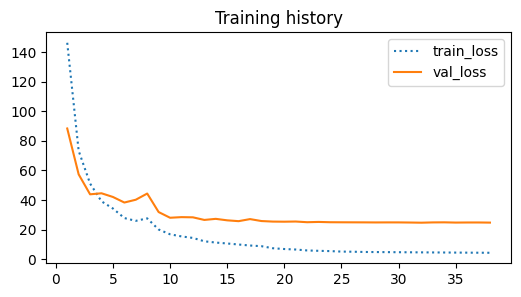

# Fold 0  24.68 0.92 322.98 1000000*600*11 2048



335.1259
Epoch 1/70
391/391 - 18s - 46ms/step - loss: 141.7639 - val_loss: 86.6543 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 71.4863 - val_loss: 64.3523 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 54.0424 - val_loss: 54.2097 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 41.1998 - val_loss: 48.1754 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 33.9875 - val_loss: 42.0051 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 29.0369 - val_loss: 43.1279 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 27.1508 - val_loss: 37.7056 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 24.0107 - val_loss: 43.3386 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 24.6892 - val_loss: 35.8689 - learning_rate: 1.0000e-03
Epoch 10/70
391/391 - 8s - 20ms/step - loss: 20.3345 - val_loss: 31.2818 - learning_rate:

# Fold 1  24.35 0.93 335.13 1000000*600*11 2048



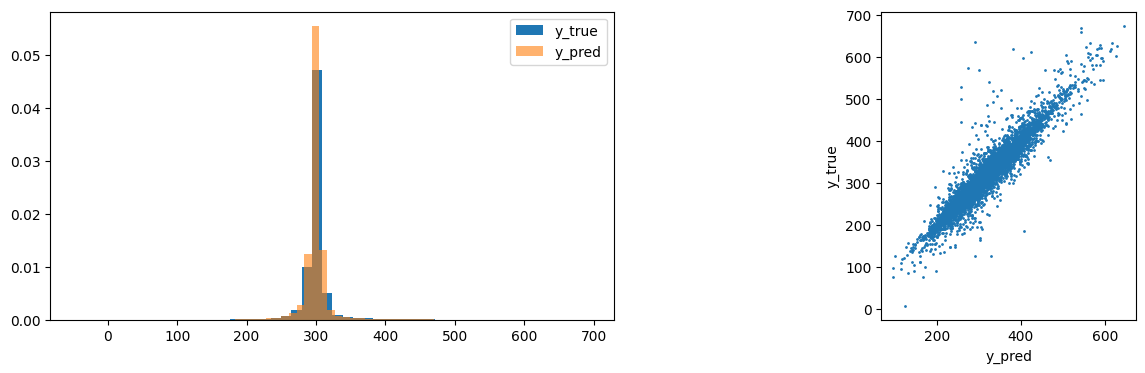

334.07724
Epoch 1/70
391/391 - 18s - 47ms/step - loss: 142.2433 - val_loss: 89.4151 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 69.7377 - val_loss: 65.1629 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 50.6780 - val_loss: 50.2691 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 40.5224 - val_loss: 48.4318 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 34.3465 - val_loss: 47.9713 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 30.2439 - val_loss: 40.7895 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 21ms/step - loss: 27.2841 - val_loss: 71.2621 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 24.8696 - val_loss: 40.1154 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 22.8147 - val_loss: 42.6939 - learning_rate: 1.0000e-03
Epoch 10/70

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257

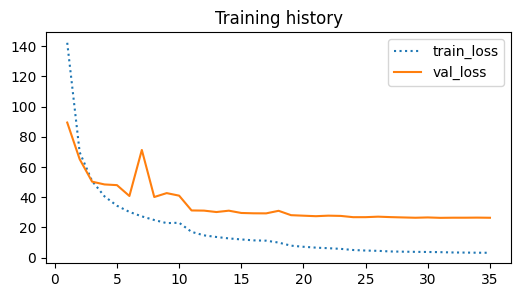

# Fold 2  26.37 0.92 334.08 1000000*600*11 2048



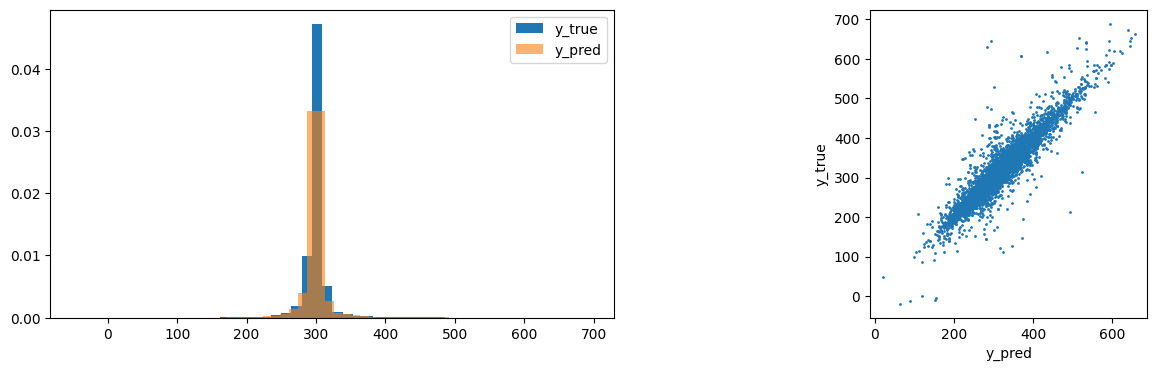

335.65823
Epoch 1/70
391/391 - 18s - 45ms/step - loss: 155.9243 - val_loss: 100.3383 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 76.9952 - val_loss: 63.1734 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 52.2768 - val_loss: 72.3320 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 41.1118 - val_loss: 44.3088 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 33.7621 - val_loss: 47.0589 - learning_rate: 1.0000e-03
Epoch 6/70

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 8s - 20ms/step - loss: 29.5022 - val_loss: 50.2200 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 22.3677 - val_loss: 34.7905 - learning_rate: 5.0000e-04
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 19.4857 - val_loss: 33.0025 - learning_rate: 5.0000e-04
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 18.5246 - val_loss: 35.7748 - learning_rate: 5.0000e-04
Epoch 10/7

# Fold 3  27.13 0.92 335.66 1000000*600*11 2048



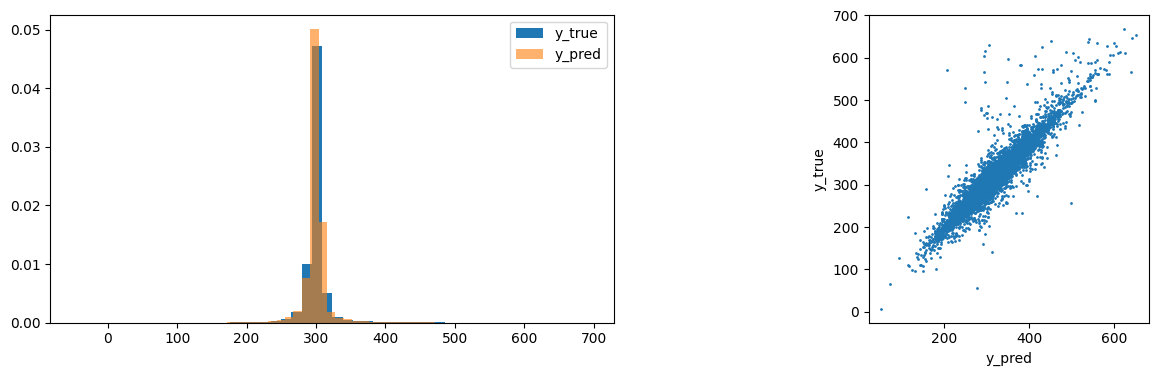

336.4547
Epoch 1/70
391/391 - 18s - 46ms/step - loss: 145.8949 - val_loss: 91.8198 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 21ms/step - loss: 73.5271 - val_loss: 85.0690 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 21ms/step - loss: 55.6492 - val_loss: 53.0201 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 42.2045 - val_loss: 48.6054 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 34.4782 - val_loss: 42.2265 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 30.3749 - val_loss: 42.2844 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 21ms/step - loss: 28.4966 - val_loss: 38.5750 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 21ms/step - loss: 25.7786 - val_loss: 40.6711 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 23.3594 - val_loss: 38.1724 - learning_rate: 1.0000e-03
Epoch 10/70
391/391 - 8s - 21ms/step - loss: 22.8317 - val_loss: 42.0933 - learning_rate:

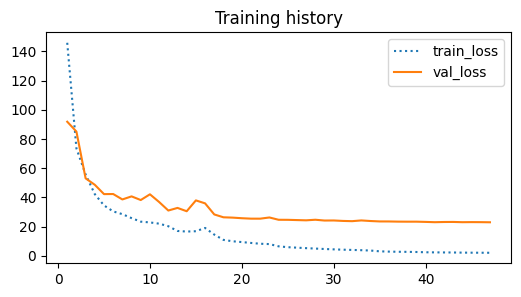

# Fold 4  22.93 0.93 336.45 1000000*600*11 2048



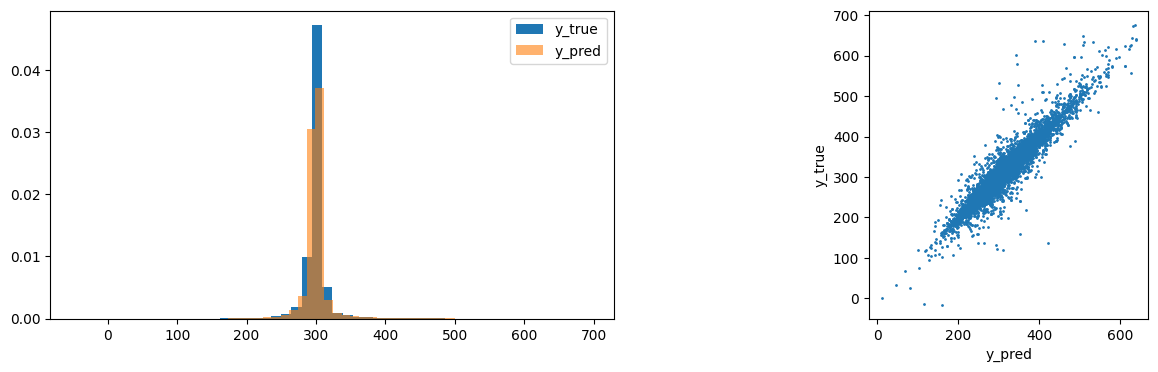

In [ ]:
grayscale_model_list = fit_model(model, initial_lr)

In [ ]:
import os

# 저장할 폴더 생성 (선택)
os.makedirs(f"{DATA_PATH}/saved_models", exist_ok=True)

# 리스트에 있는 모델들을 하나씩 저장
for i, model in enumerate(grayscale_model_list):
    # .keras 포맷이 최신 표준입니다 (.h5도 가능)
    save_path = f"{DATA_PATH}/saved_models/fold_{i}_model.keras"
    model.save(save_path)
    print(f"Saved: {save_path}")

Saved: drive/MyDrive/ml_project/saved_models/fold_0_model.keras
Saved: drive/MyDrive/ml_project/saved_models/fold_1_model.keras
Saved: drive/MyDrive/ml_project/saved_models/fold_2_model.keras
Saved: drive/MyDrive/ml_project/saved_models/fold_3_model.keras
Saved: drive/MyDrive/ml_project/saved_models/fold_4_model.keras


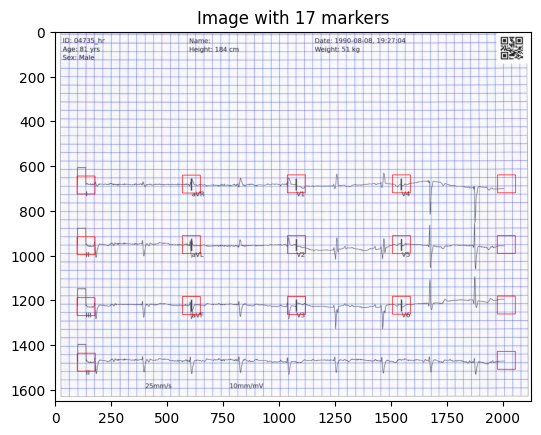

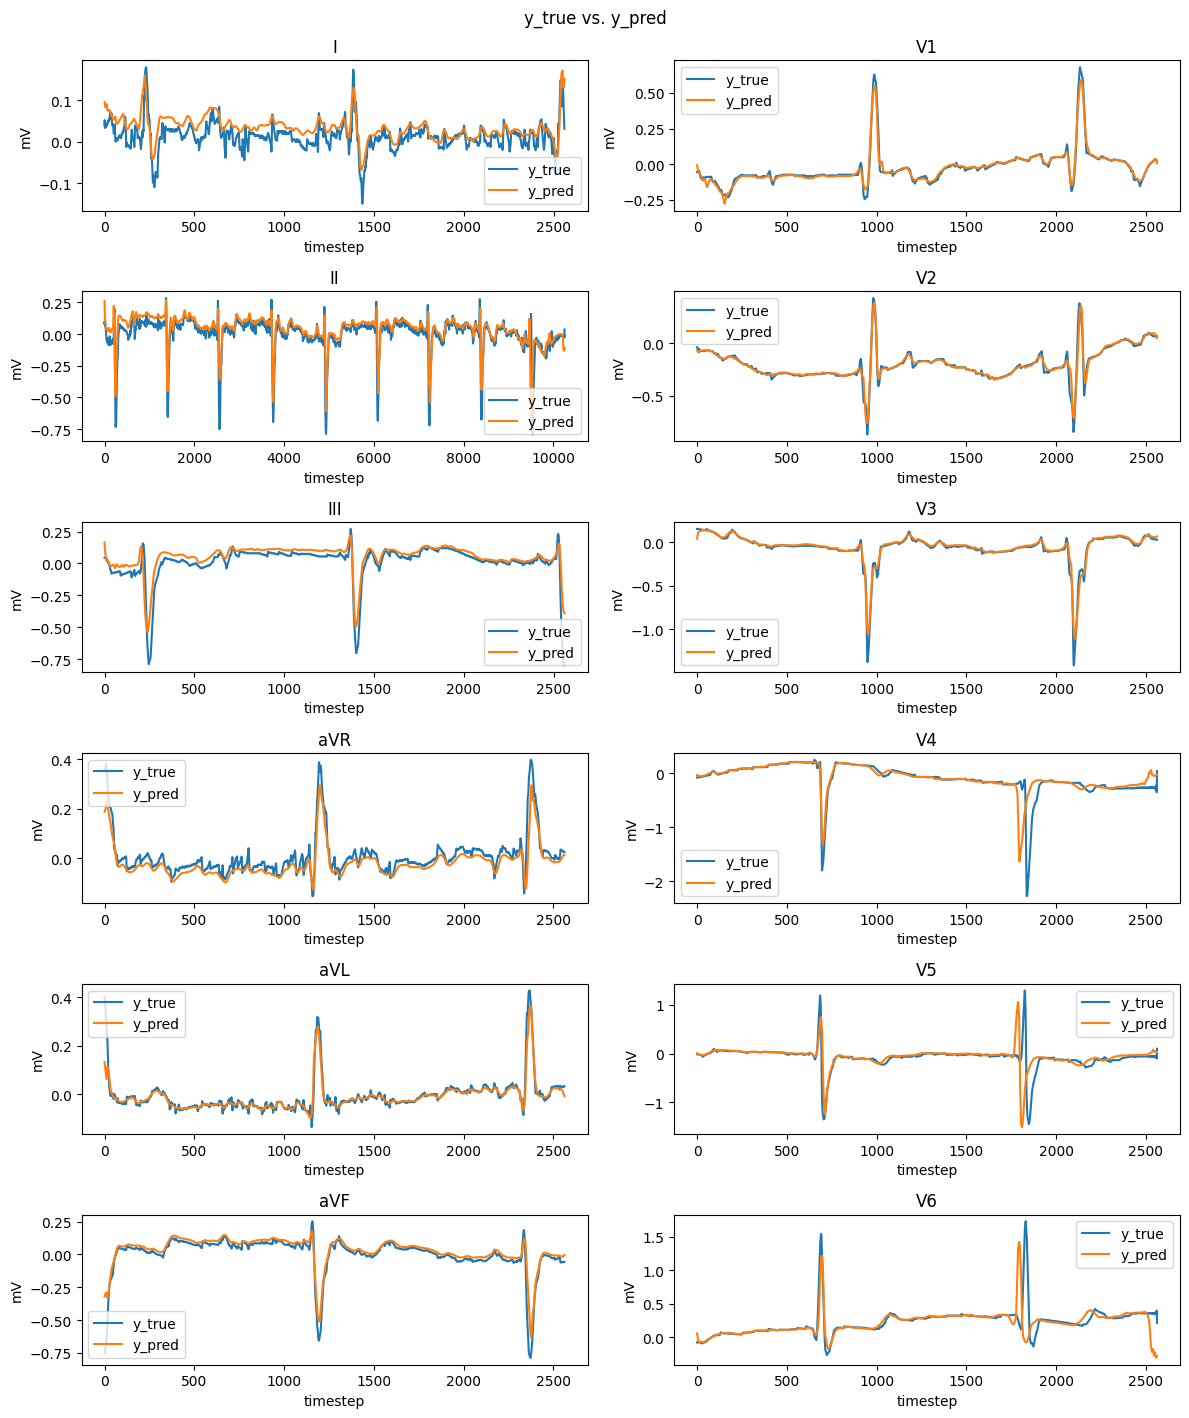

idx= 900 img_type= 3 SNR:  3.24


idx= 900 img_type= 4 SNR:  2.88
idx= 900 img_type=11 SNR:  3.26
idx= 900 img_type=12 SNR:  2.91
idx= 901 img_type= 3 SNR:  3.38
idx= 901 img_type= 4 SNR:  2.97
idx= 901 img_type=11 SNR:  3.01
idx= 901 img_type=12 SNR:  2.94
idx= 902 img_type= 3 SNR:  3.55
idx= 902 img_type= 4 SNR:  3.37
idx= 902 img_type=11 SNR:  2.91
idx= 902 img_type=12 SNR:  2.86
idx= 903 img_type= 3 SNR:  2.13
idx= 903 img_type= 4 SNR:  2.13
idx= 903 img_type=11 SNR:  2.00
idx= 903 img_type=12 SNR:  2.08
idx= 904 img_type= 3 SNR:  2.84
idx= 904 img_type= 4 SNR:  2.40
idx= 904 img_type=11 SNR:  2.60
idx= 904 img_type=12 SNR:  2.59
idx= 905 img_type= 3 SNR:  2.40
idx= 905 img_type= 4 SNR:  2.17
idx= 905 img_type=11 SNR:  2.96
idx= 905 img_type=12 SNR:  1.69
idx= 906 img_type= 3 SNR:  3.95
idx= 906 img_type= 4 SNR:  2.63
idx= 906 img_type=11 SNR:  3.64
idx= 906 img_type=12 SNR:  2.48
idx= 907 img_type= 3 SNR:  2.77
idx= 907 img_type= 4 SNR:  2.13
idx= 907 img_type=11 SNR:  3.08
idx= 9

In [ ]:
validate_algorithm(convert_scanned_grayscale, start=900, end=910, image_types=[3, 4, 11, 12])

### 2. DNN (6 layers)

In [ ]:
def deep_regression_model():
    """A dense feed-forward with 6 hidden layers."""
    initial_lr = 0.001 # fix: lower lr
    noise = 0.1
    x_input = Input(shape=(X.shape[-1], ))
    x = x_input
    x = GaussianNoise(noise)(x)
    x = Dense(units=4096, activation='selu')(x)
    x = Dense(units=2048, activation='selu')(x)
    x = Dense(units=1024, activation='selu')(x)
    x = Dense(units=512, activation='selu')(x)
    x = Dense(units=256, activation='selu')(x)
    x = Dense(units=256, activation='selu')(x)
    x_output = Dense(units=1, activation='linear', bias_initializer=Constant(h0 / 2))(x)

    model = Model(inputs=x_input, outputs=x_output)
    return model, initial_lr

model, intial_lr = deep_regression_model()
model(X[0:5]).shape
model.summary()

322.97797
Epoch 1/70
391/391 - 20s - 51ms/step - loss: 145.9598 - val_loss: 81.8271 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 21ms/step - loss: 71.8551 - val_loss: 55.8770 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 21ms/step - loss: 50.4404 - val_loss: 55.9532 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 21ms/step - loss: 40.7191 - val_loss: 46.1406 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 35.0810 - val_loss: 42.2820 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 29.2400 - val_loss: 41.1985 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 25.9296 - val_loss: 39.0244 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 23.8682 - val_loss: 35.2042 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 21ms/step - loss: 20.7282 - val_loss: 33.2597 - learning_rate: 1.0000e-03
Epoch 10/70
391/391 - 8s - 20ms/step - loss: 19.6817 - val_loss: 30.9847 - learning_rate

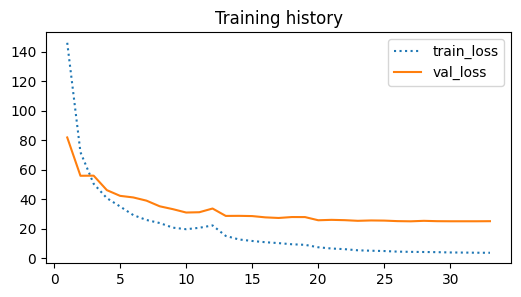

# Fold 0  25.12 0.92 322.98 1000000*600*11 2048



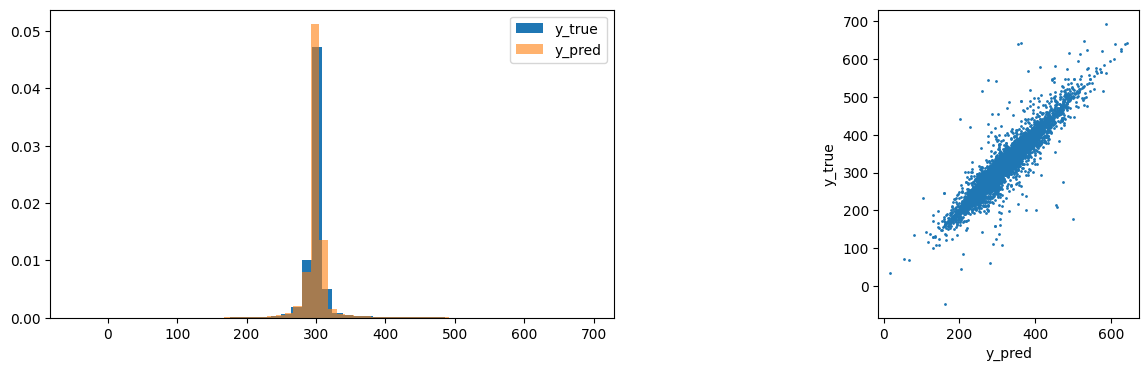

335.1259
Epoch 1/70
391/391 - 18s - 46ms/step - loss: 145.7958 - val_loss: 90.1675 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 73.2353 - val_loss: 65.4761 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 53.4538 - val_loss: 69.5387 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 41.1912 - val_loss: 45.5969 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 33.1778 - val_loss: 40.2833 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 29.1307 - val_loss: 38.9402 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 27.9438 - val_loss: 45.9873 - learning_rate: 1.0000e-03
Epoch 8/70

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 8s - 21ms/step - loss: 26.6474 - val_loss: 46.4919 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 19.7979 - val_loss: 35.6846 - learning_rate: 5.0000e-04
Epoch 10/70


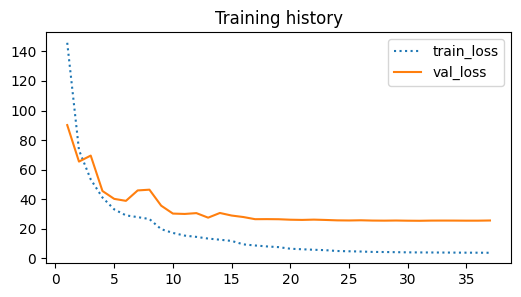

# Fold 1  25.67 0.92 335.13 1000000*600*11 2048



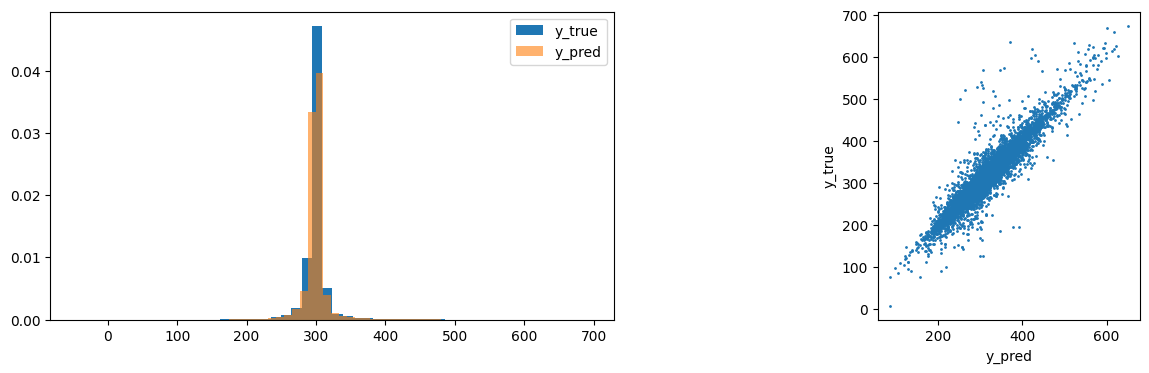

334.07724
Epoch 1/70
391/391 - 18s - 46ms/step - loss: 145.7201 - val_loss: 95.8265 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 70.7719 - val_loss: 61.2680 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 21ms/step - loss: 51.3683 - val_loss: 52.9362 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 41.4408 - val_loss: 52.6021 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 21ms/step - loss: 33.8641 - val_loss: 45.0996 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 28.9000 - val_loss: 39.6614 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 27.0612 - val_loss: 41.8885 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 23.9910 - val_loss: 35.9072 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 20.7445 - val_loss: 35.3198 - learning_rate: 1.0000e-03
Epoch 10/70
391/391 - 8s - 20ms/step - loss: 20.6473 - val_loss: 44.8459 - learning_rate

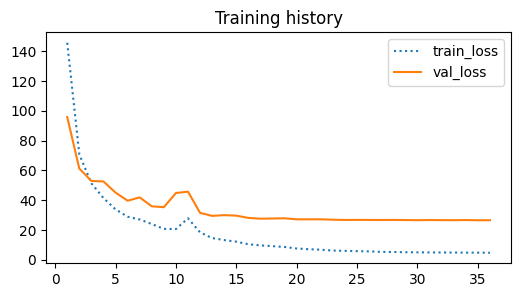

# Fold 2  26.56 0.92 334.08 1000000*600*11 2048



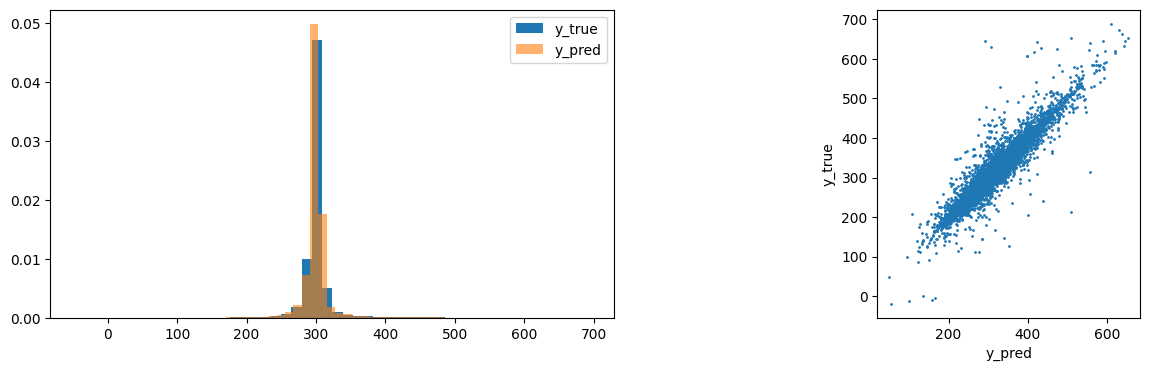

335.65823
Epoch 1/70
391/391 - 18s - 46ms/step - loss: 147.9494 - val_loss: 86.8050 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 73.6069 - val_loss: 63.1027 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 52.1462 - val_loss: 53.2169 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 39.8797 - val_loss: 48.9719 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 33.9799 - val_loss: 39.5693 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 31.0279 - val_loss: 39.4344 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 26.4295 - val_loss: 34.4457 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 25.3415 - val_loss: 42.8747 - learning_rate: 1.0000e-03
Epoch 9/70

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 8s - 20ms/step - loss: 23.9461 - val_loss: 38.7437 - learning_rate: 1.0000e-03
Epoch 10/70

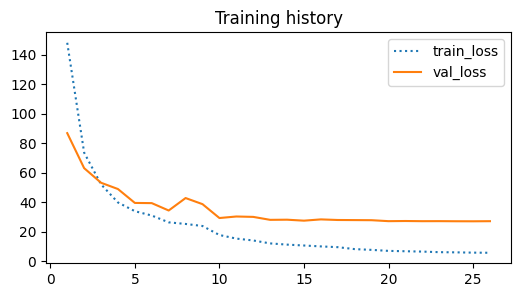

# Fold 3  27.21 0.92 335.66 1000000*600*11 2048



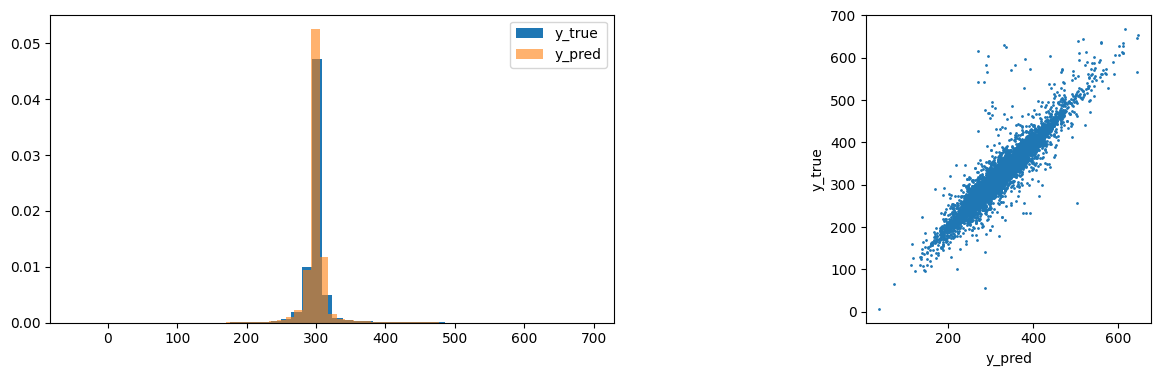

336.4547
Epoch 1/70
391/391 - 18s - 46ms/step - loss: 150.0682 - val_loss: 95.1540 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 8s - 20ms/step - loss: 75.1546 - val_loss: 63.4043 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 8s - 20ms/step - loss: 54.3143 - val_loss: 62.3431 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 8s - 20ms/step - loss: 40.9758 - val_loss: 53.2502 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 8s - 20ms/step - loss: 34.3854 - val_loss: 48.6370 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 8s - 20ms/step - loss: 32.2568 - val_loss: 39.0868 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 8s - 20ms/step - loss: 26.1247 - val_loss: 44.4005 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 8s - 20ms/step - loss: 23.2104 - val_loss: 35.5398 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 8s - 20ms/step - loss: 22.5633 - val_loss: 35.9860 - learning_rate: 1.0000e-03
Epoch 10/70
391/391 - 8s - 20ms/step - loss: 20.7437 - val_loss: 35.1116 - learning_rate:

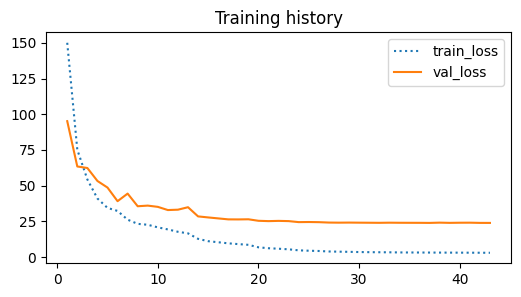

# Fold 4  23.86 0.93 336.45 1000000*600*11 2048



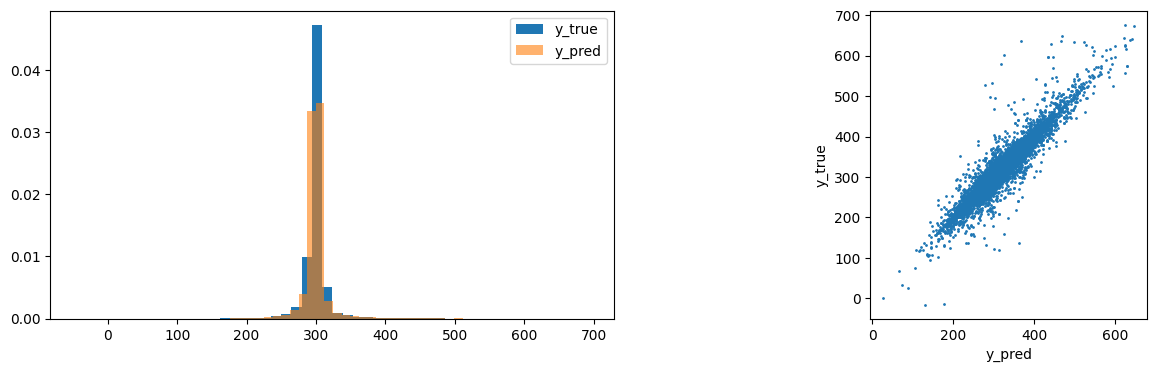

In [ ]:
grayscale_model_list = fit_model(model, initial_lr)

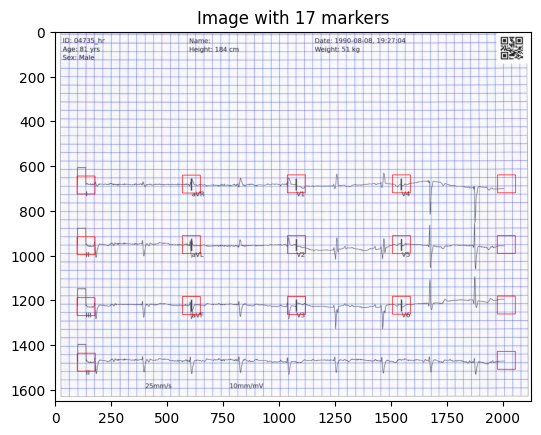

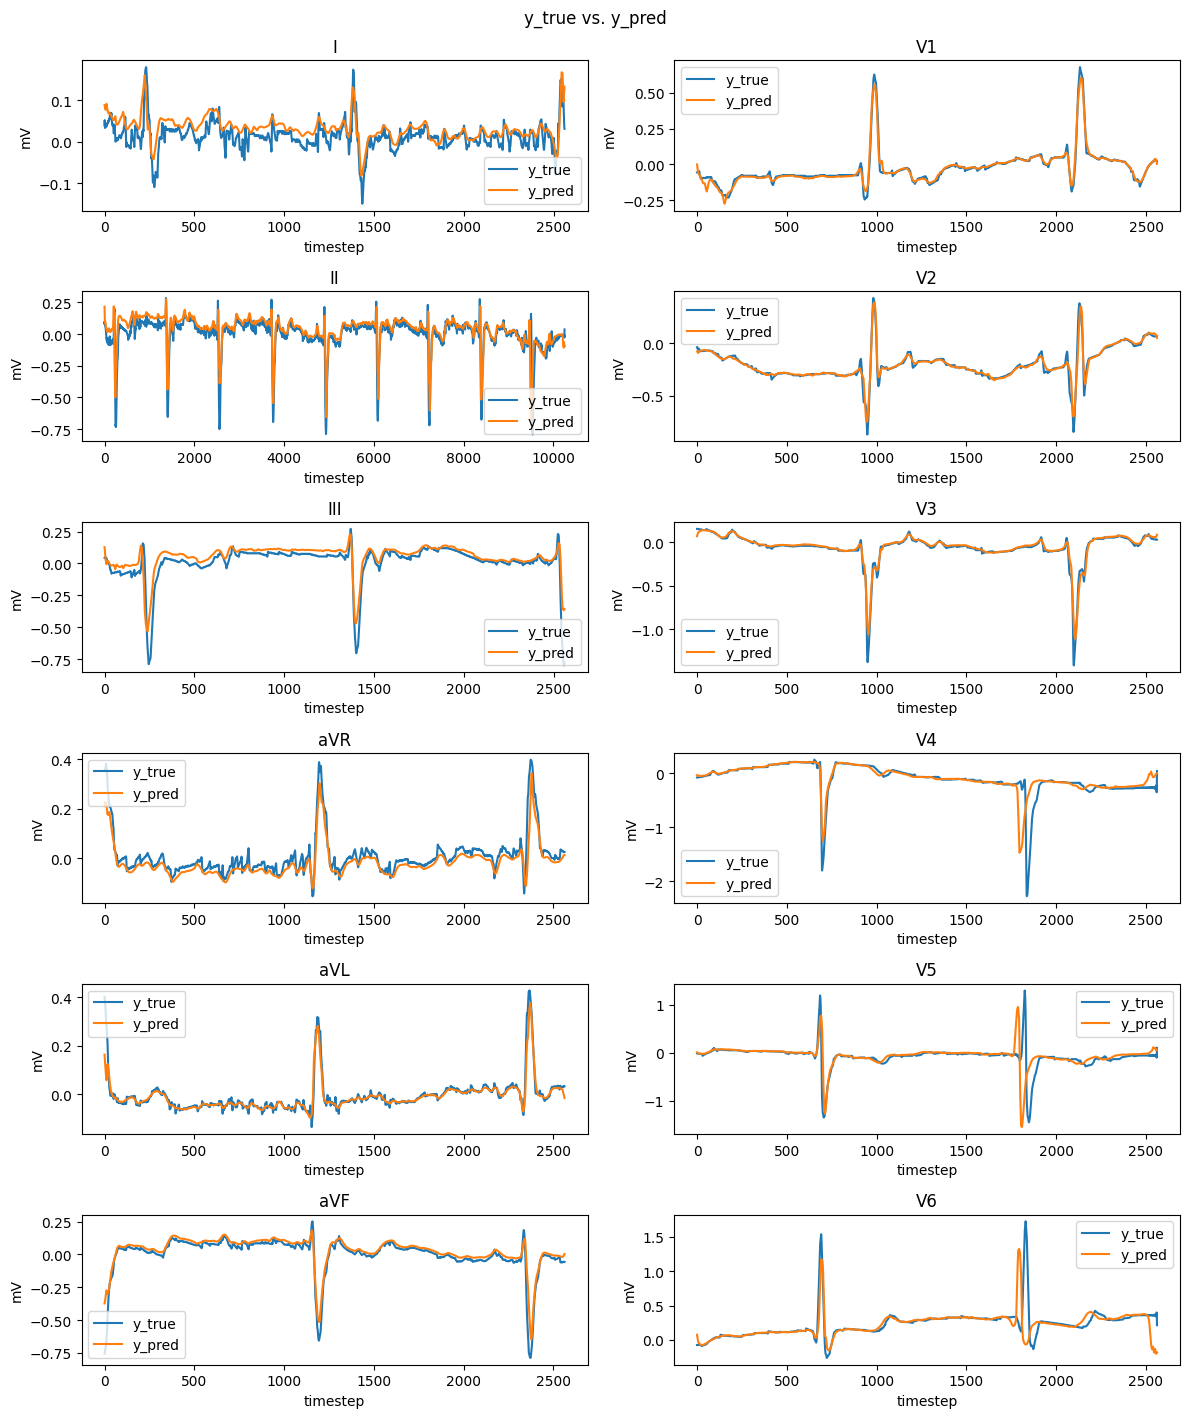

idx= 900 img_type= 3 SNR:  3.26


idx= 900 img_type= 4 SNR:  2.89
idx= 900 img_type=11 SNR:  3.29
idx= 900 img_type=12 SNR:  2.93
idx= 901 img_type= 3 SNR:  3.41
idx= 901 img_type= 4 SNR:  3.03
idx= 901 img_type=11 SNR:  3.03
idx= 901 img_type=12 SNR:  2.83
idx= 902 img_type= 3 SNR:  3.56
idx= 902 img_type= 4 SNR:  3.34
idx= 902 img_type=11 SNR:  2.91
idx= 902 img_type=12 SNR:  2.83
idx= 903 img_type= 3 SNR:  2.10
idx= 903 img_type= 4 SNR:  2.15
idx= 903 img_type=11 SNR:  2.06
idx= 903 img_type=12 SNR:  2.05
idx= 904 img_type= 3 SNR:  2.86
idx= 904 img_type= 4 SNR:  2.42
idx= 904 img_type=11 SNR:  2.56
idx= 904 img_type=12 SNR:  2.67
idx= 905 img_type= 3 SNR:  2.33
idx= 905 img_type= 4 SNR:  2.14
idx= 905 img_type=11 SNR:  3.00
idx= 905 img_type=12 SNR:  1.79
idx= 906 img_type= 3 SNR:  3.97
idx= 906 img_type= 4 SNR:  2.58
idx= 906 img_type=11 SNR:  3.56
idx= 906 img_type=12 SNR:  2.47
idx= 907 img_type= 3 SNR:  2.77
idx= 907 img_type= 4 SNR:  2.17
idx= 907 img_type=11 SNR:  3.10
idx= 9

In [ ]:
validate_algorithm(convert_scanned_grayscale, start=900, end=910, image_types=[3, 4, 11, 12])

### 3. 1D CNN

In [ ]:
from tensorflow.keras.layers import Reshape, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Activation, GlobalAveragePooling1D

from tensorflow.keras.layers import Reshape, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Activation, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import Constant # Note: Constant initializer is not used in this version but imported in the prior request context.

def cnn_1d_model():
    initial_lr = 0.001

    # Input: (Batch, 6600) -> Reshape to 1D Time Series (Batch, 600, 11)
    # 600: Time steps, 11: Features/Channels
    x_input = Input(shape=(X.shape[-1], ))
    x = Reshape((600, 11))(x_input)


    # 1. Feature Extraction (Conv1D)
    # Use larger kernel sizes (7~15) for potentially thicker signal lines.
    x = Conv1D(filters=32, kernel_size=11, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Apply minimal pooling to preserve positional information.
    x = MaxPooling1D(pool_size=2)(x) # 600 -> 300

    x = Conv1D(filters=64, kernel_size=7, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x) # 300 -> 150

    x = Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # No further pooling to maintain time resolution/details

    x = Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 2. Regression Prediction

    # Flatten the tensor. (Do NOT use GlobalAveragePooling1D to preserve location info)
    x = Flatten()(x)

    # Dense Layers
    x = Dense(256, activation='selu', kernel_initializer='lecun_normal')(x)
    x = Dense(128, activation='selu', kernel_initializer='lecun_normal')(x)

    # Final Output: Single linear regression prediction
    x_output = Dense(1, activation='linear')(x)

    model = Model(inputs=x_input, outputs=x_output)
    return model, initial_lr

model, initial_lr = cnn_1d_model()
model(X[0:5]).shape
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 6600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 600, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 600, 32)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 600, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 600, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 300, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 300, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 300, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 300, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 150, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 150, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 150, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     9,830,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,023,553 (38.24 MB)

 Trainable params: 10,022,593 (38.23 MB)

 Non-trainable params: 960 (3.75 KB)

322.97797
Epoch 1/70
391/391 - 35s - 89ms/step - loss: 844.9069 - val_loss: 1081.2151 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 15s - 39ms/step - loss: 96.7002 - val_loss: 97.4860 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 15s - 39ms/step - loss: 77.7834 - val_loss: 74.9485 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 15s - 39ms/step - loss: 68.3875 - val_loss: 68.0413 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 15s - 39ms/step - loss: 60.2832 - val_loss: 95.0118 - learning_rate: 1.0000e-03
Epoch 6/70
391/391 - 15s - 39ms/step - loss: 55.5930 - val_loss: 63.2483 - learning_rate: 1.0000e-03
Epoch 7/70
391/391 - 15s - 39ms/step - loss: 48.4310 - val_loss: 48.7583 - learning_rate: 1.0000e-03
Epoch 8/70
391/391 - 15s - 39ms/step - loss: 42.4824 - val_loss: 44.6081 - learning_rate: 1.0000e-03
Epoch 9/70
391/391 - 15s - 39ms/step - loss: 38.8012 - val_loss: 42.6606 - learning_rate: 1.0000e-03
Epoch 10/70
391/391 - 15s - 39ms/step - loss: 34.9136 - val_loss: 31.3764 - le

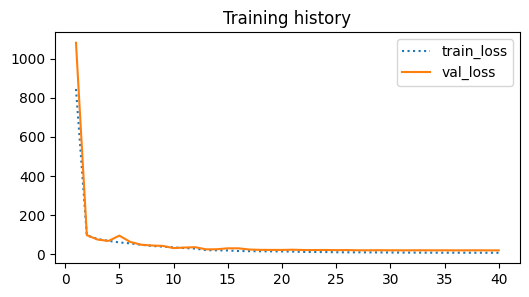

# Fold 0  19.77 0.94 322.98 1000000*600*11 2048



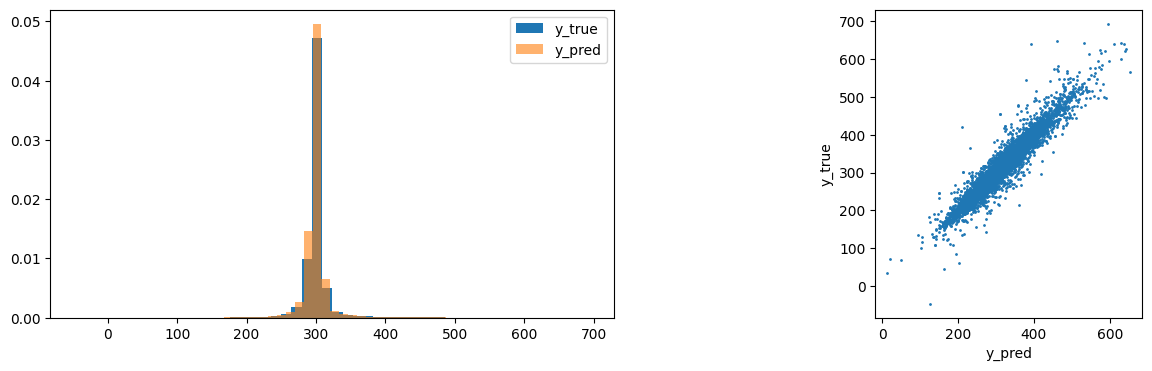

335.1259
Epoch 1/70
391/391 - 31s - 80ms/step - loss: 48.7625 - val_loss: 17.1525 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 15s - 39ms/step - loss: 16.0181 - val_loss: 31.7688 - learning_rate: 1.0000e-03
Epoch 3/70

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 15s - 39ms/step - loss: 17.3910 - val_loss: 20.8050 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 15s - 39ms/step - loss: 11.4969 - val_loss: 12.7019 - learning_rate: 5.0000e-04
Epoch 5/70
391/391 - 15s - 39ms/step - loss: 10.5656 - val_loss: 15.0826 - learning_rate: 5.0000e-04
Epoch 6/70

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 - 15s - 39ms/step - loss: 10.2538 - val_loss: 15.4604 - learning_rate: 5.0000e-04
Epoch 7/70
391/391 - 16s - 40ms/step - loss: 8.4090 - val_loss: 11.5624 - learning_rate: 2.5000e-04
Epoch 8/70
391/391 - 15s - 39ms/step - loss: 7.8880 - val_loss: 12.1820 - learning_rate: 2.5000e-04
Epoch 9/70

Epoch 9: ReduceLROn

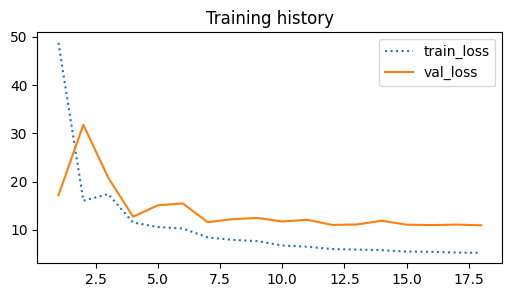

# Fold 1  10.93 0.97 335.13 1000000*600*11 2048



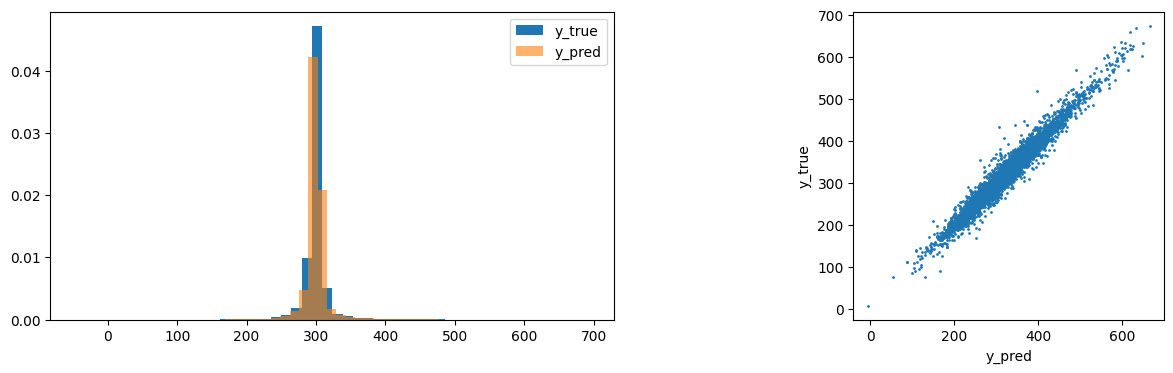

334.07724
Epoch 1/70
391/391 - 31s - 79ms/step - loss: 60.1688 - val_loss: 10.5705 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 15s - 39ms/step - loss: 10.1247 - val_loss: 12.7712 - learning_rate: 1.0000e-03
Epoch 3/70

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 15s - 38ms/step - loss: 10.5459 - val_loss: 14.8767 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 15s - 39ms/step - loss: 8.1256 - val_loss: 10.0845 - learning_rate: 5.0000e-04
Epoch 5/70
391/391 - 15s - 39ms/step - loss: 7.4317 - val_loss: 14.6764 - learning_rate: 5.0000e-04
Epoch 6/70

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 - 15s - 40ms/step - loss: 7.3456 - val_loss: 10.2133 - learning_rate: 5.0000e-04
Epoch 7/70
391/391 - 15s - 39ms/step - loss: 6.0736 - val_loss: 11.6896 - learning_rate: 2.5000e-04
Epoch 8/70
391/391 - 15s - 39ms/step - loss: 5.7238 - val_loss: 8.2728 - learning_rate: 2.5000e-04
Epoch 9/70
391/391 - 15s - 39ms/st

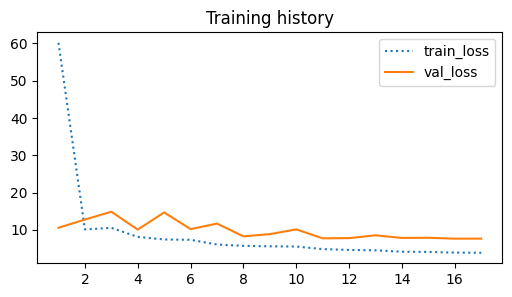

# Fold 2   7.66 0.98 334.08 1000000*600*11 2048



335.65823
Epoch 1/70
391/391 - 31s - 80ms/step - loss: 43.8430 - val_loss: 11.8129 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 15s - 39ms/step - loss: 8.6503 - val_loss: 14.8631 - learning_rate: 1.0000e-03
Epoch 3/70

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 15s - 39ms/step - loss: 9.9140 - val_loss: 12.8945 - learning_rate: 1.0000e-03
Epoch 4/70
391/391 - 15s - 39ms/step - loss: 6.8192 - val_loss: 7.0622 - learning_rate: 5.0000e-04
Epoch 5/70
391/391 - 15s - 39ms/step - loss: 5.6075 - val_loss: 7.3864 - learning_rate: 5.0000e-04
Epoch 6/70

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 - 15s - 39ms/step - loss: 5.4506 - val_loss: 7.5127 - learning_rate: 5.0000e-04
Epoch 7/70
391/391 - 15s - 39ms/step - loss: 4.5121 - val_loss: 5.9870 - learning_rate: 2.5000e-04
Epoch 8/70
391/391 - 15s - 39ms/step - loss: 4.2080 - val_loss: 8.8707 - learning_rate: 2.5000e-04
Epoch 9/70

Epoch 9: ReduceLROnPlateau r

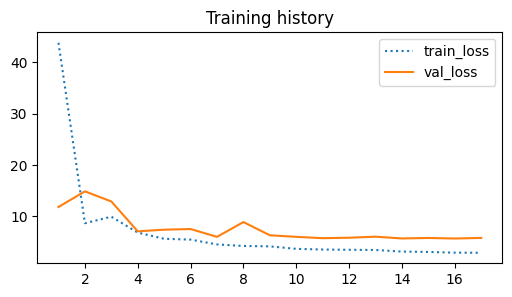

# Fold 3   5.77 0.98 335.66 1000000*600*11 2048



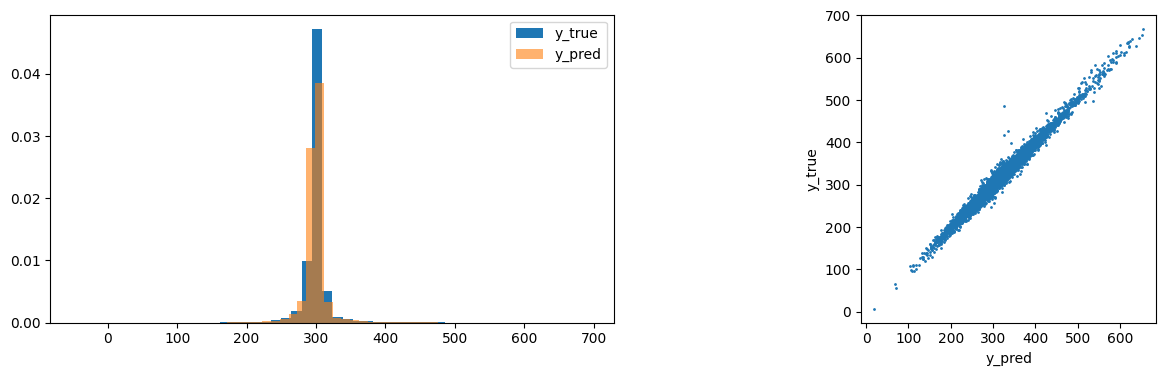

336.4547
Epoch 1/70
391/391 - 31s - 80ms/step - loss: 40.9757 - val_loss: 5.7097 - learning_rate: 1.0000e-03
Epoch 2/70
391/391 - 15s - 39ms/step - loss: 5.5904 - val_loss: 5.4028 - learning_rate: 1.0000e-03
Epoch 3/70
391/391 - 15s - 39ms/step - loss: 6.5742 - val_loss: 8.6858 - learning_rate: 1.0000e-03
Epoch 4/70

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 - 15s - 39ms/step - loss: 8.2328 - val_loss: 11.2125 - learning_rate: 1.0000e-03
Epoch 5/70
391/391 - 15s - 39ms/step - loss: 5.4425 - val_loss: 5.1148 - learning_rate: 5.0000e-04
Epoch 6/70
391/391 - 15s - 39ms/step - loss: 4.3186 - val_loss: 4.7760 - learning_rate: 5.0000e-04
Epoch 7/70
391/391 - 15s - 39ms/step - loss: 4.3000 - val_loss: 12.3588 - learning_rate: 5.0000e-04
Epoch 8/70

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 - 15s - 39ms/step - loss: 4.4369 - val_loss: 5.7765 - learning_rate: 5.0000e-04
Epoch 9/70
391/391 - 15s - 39ms/step - los

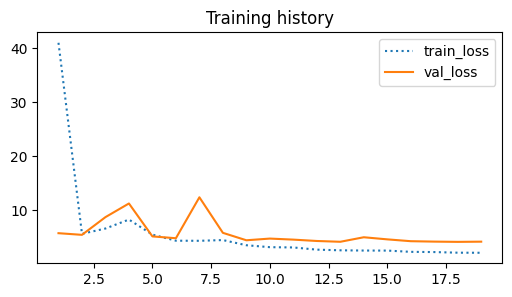

# Fold 4   4.14 0.99 336.45 1000000*600*11 2048



In [ ]:
grayscale_model_list = fit_model(model=model, initial_lr=initial_lr)

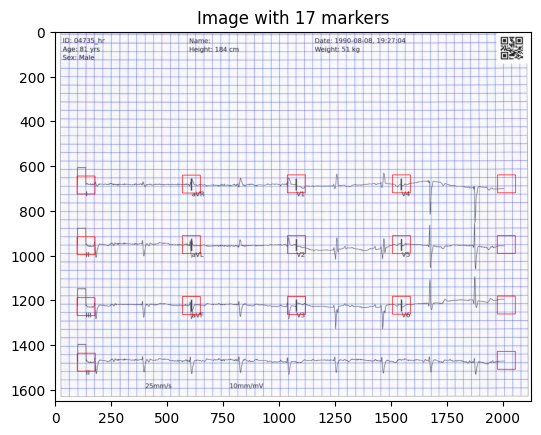

idx= 900 img_type= 3 SNR:  1.74


idx= 900 img_type= 4 SNR:  2.87
idx= 900 img_type=11 SNR:  1.61
idx= 900 img_type=12 SNR:  2.60
idx= 901 img_type= 3 SNR:  2.02
idx= 901 img_type= 4 SNR:  3.10
idx= 901 img_type=11 SNR:  1.69
idx= 901 img_type=12 SNR:  2.88
idx= 902 img_type= 3 SNR:  2.02
idx= 902 img_type= 4 SNR:  3.40
idx= 902 img_type=11 SNR:  1.92
idx= 902 img_type=12 SNR:  2.48
idx= 903 img_type= 3 SNR:  1.30
idx= 903 img_type= 4 SNR:  2.29
idx= 903 img_type=11 SNR:  1.28
idx= 903 img_type=12 SNR:  2.42
idx= 904 img_type= 3 SNR:  1.84
idx= 904 img_type= 4 SNR:  2.68
idx= 904 img_type=11 SNR:  1.85
idx= 904 img_type=12 SNR:  2.89
idx= 905 img_type= 3 SNR:  1.22
idx= 905 img_type= 4 SNR:  2.21
idx= 905 img_type=11 SNR:  1.21
idx= 905 img_type=12 SNR:  2.66
idx= 906 img_type= 3 SNR:  1.51
idx= 906 img_type= 4 SNR:  2.74
idx= 906 img_type=11 SNR:  1.52
idx= 906 img_type=12 SNR:  2.74
idx= 907 img_type= 3 SNR:  1.54
idx= 907 img_type= 4 SNR:  2.58
idx= 907 img_type=11 SNR:  1.48
idx= 9

In [ ]:
validate_algorithm(convert_scanned_grayscale, start=900, end=910, image_types=[3, 4, 11, 12])

### 4. 2D CNN

In [ ]:
from tensorflow.keras.layers import Reshape, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import Constant

def cnn_regression_model():
    initial_lr = 0.001

    # 1. Input (1D Vector)
    x_input = Input(shape=(X.shape[-1], ))

    # 2. Reshape to 2D: Treat as a (H, W, 1) image
    h0, w0 = 600, 11
    x = Reshape((h0, w0, 1))(x_input)
    [Image of a 1D vector being reshaped into a 2D grid with a single channel]

    # 3. CNN Feature Extraction

    # Conv Block 1: 32 filters, halve height
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 1))(x)

    # Conv Block 2: 64 filters, halve height and width
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Conv Block 3: 128 filters
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4. Regression Prediction

    # Flatten 2D feature map to 1D vector
    x = Flatten()(x)

    # Dense Layers (Feature Learning)
    x = Dense(256, activation='selu')(x)
    x = Dense(128, activation='selu')(x)

    # Final Output: 1 value (Linear Regression)
    x_output = Dense(units=1, activation='linear', bias_initializer=Constant(h0 / 2))(x)

    model = Model(inputs=x_input, outputs=x_output)
    return model, initial_lr

model, initial_lr = cnn_regression_model()
model(X[0:5]).shape
model.summary()

In [ ]:
grayscale_model_list = fit_model(model, initial_lr)

In [ ]:
validate_algorithm(convert_scanned_grayscale, start=900, end=910, image_types=[3, 4, 11, 12])